# Lab 6 - Decision Trees & Random Forests

## Decision Tree Background & Representation

Decision Trees are an important type of algorithm for predictive modeling machine learning. The classical decision tree algorithms have been around for decades and modern variations like random forest are among the most powerful techniques available. On some platforms like R, they are also known as Classification and Regression Trees (or "CART" for short). The CART algorithm also forms the basis of some other models like bagged decision trees, random forest and boosted decision trees.

| |
|-|
|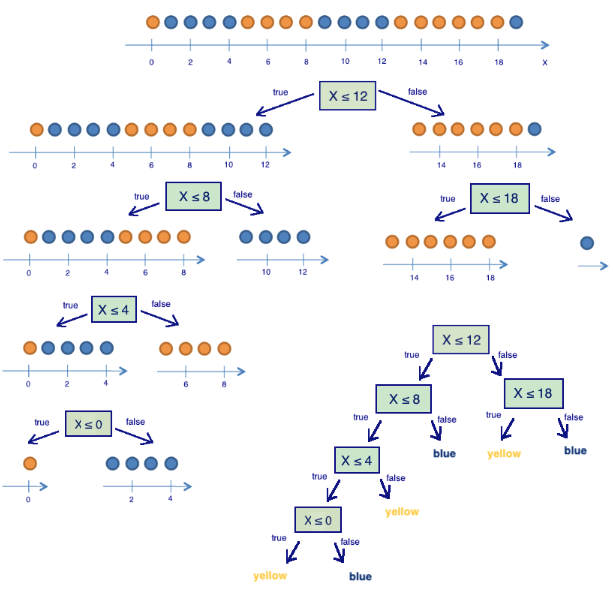|
|Source: [Kashnitsky, Y. (2019). Topic 3 - Decision Trees and kNN. Open Machine Learning Course (openml.ai)](https://www.kaggle.com/kashnitsky/topic-3-decision-trees-and-knn)|

The representation for the CART model is a binary tree, which you may recall from CSEN301 algorithms and data structures. Each root node represents a single input variable (x) and a split point on that variable (assuming the variable is numeric), while the leaf nodes of the tree contain an output variable (y), which is used to make a prediction.

Given a new input, the tree is traversed by evaluating the specific input started at the root node of the tree.

**Advantages** of decision trees include:
* Simple to understand and to interpret. Trees can be visualized.
* Requires little data preparation.
* Able to handle both numerical and categorical data.
* Possible to validate a model using statistical tests.
* Performs well even if its assumptions are somewhat violated by the true model from which the data were generated.

**Disadvantages** of decision trees include:
* Overfitting. Mechanisms such as pruning (not currently supported), setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.
* Decision trees can be unstable. Mitigant: Use decision trees within an ensemble.
* Cannot guarantee to return the globally optimal decision tree. Mitigant: Training multiple trees in an ensemble learner
* Decision tree learners create biased trees if some classes dominate. Recommendation: Balance the dataset prior to fitting

## Problem Background and Task

This is a fictional data set created by IBM data scientists for studying employee attrition (i.e. employee turnover). In this lab, we'd like to:
  1. Uncover some of the factors that lead to employee attrition
  2. Create a model that predicts employee attrition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use("seaborn")

<ipython-input-1-c89f6c412c78>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
try:
    df = pd.read_csv('../data/hr_employee_attrition.csv')
except:
    df = pd.read_csv('https://raw.githubusercontent.com/GUC-DM/W2023/main/data/hr_employee_attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## Exploratory Data Analysis

As always, we must first inspect the dataset and visualize it to better understand the problem/data we're dealing with.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [4]:
pd.set_option("display.float_format", "{:.2f}".format)
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,...,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00
mean,36.92,802.49,9.19,2.91,1.00,1024.87,2.72,65.89,2.73,2.06,...,2.71,80.00,0.79,11.28,2.80,2.76,7.01,4.23,2.19,4.12
std,9.14,403.51,8.11,1.02,0.00,602.02,1.09,20.33,0.71,1.11,...,1.08,0.00,0.85,7.78,1.29,0.71,6.13,3.62,3.22,3.57
min,18.00,102.00,1.00,1.00,1.00,1.00,1.00,30.00,1.00,1.00,...,1.00,80.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
25%,30.00,465.00,2.00,2.00,1.00,491.25,2.00,48.00,2.00,1.00,...,2.00,80.00,0.00,6.00,2.00,2.00,3.00,2.00,0.00,2.00
50%,36.00,802.00,7.00,3.00,1.00,1020.50,3.00,66.00,3.00,2.00,...,3.00,80.00,1.00,10.00,3.00,3.00,5.00,3.00,1.00,3.00
75%,43.00,1157.00,14.00,4.00,1.00,1555.75,4.00,83.75,3.00,3.00,...,4.00,80.00,1.00,15.00,3.00,3.00,9.00,7.00,3.00,7.00
max,60.00,1499.00,29.00,5.00,1.00,2068.00,4.00,100.00,4.00,5.00,...,4.00,80.00,3.00,40.00,6.00,4.00,40.00,18.00,15.00,17.00


In [5]:
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

Checking the unique values for each column

In [6]:
for column in df.columns:
    print(f"{column} : {df[column].unique()}")
    print("====================================")

Age : [41 49 37 33 27 32 59 30 38 36 35 29 31 34 28 22 53 24 21 42 44 46 39 43
 50 26 48 55 45 56 23 51 40 54 58 20 25 19 57 52 47 18 60]
Attrition : ['Yes' 'No']
BusinessTravel : ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
DailyRate : [1102  279 1373 1392  591 1005 1324 1358  216 1299  809  153  670 1346
  103 1389  334 1123 1219  371  673 1218  419  391  699 1282 1125  691
  477  705  924 1459  125  895  813 1273  869  890  852 1141  464 1240
 1357  994  721 1360 1065  408 1211 1229  626 1434 1488 1097 1443  515
  853 1142  655 1115  427  653  989 1435 1223  836 1195 1339  664  318
 1225 1328 1082  548  132  746  776  193  397  945 1214  111  573 1153
 1400  541  432  288  669  530  632 1334  638 1093 1217 1353  120  682
  489  807  827  871  665 1040 1420  240 1280  534 1456  658  142 1127
 1031 1189 1354 1467  922  394 1312  750  441  684  249  841  147  528
  594  470  957  542  802 1355 1150 1329  959 1033 1316  364  438  689
  201 1427  857  933 1181 1395  662 1436  194  

Checking the number of unique values for each column

In [7]:
for column in df.columns:
    print(f"{column}: Number of unique values {df[column].nunique()}")
    print("==========================================================")

Age: Number of unique values 43
Attrition: Number of unique values 2
BusinessTravel: Number of unique values 3
DailyRate: Number of unique values 886
Department: Number of unique values 3
DistanceFromHome: Number of unique values 29
Education: Number of unique values 5
EducationField: Number of unique values 6
EmployeeCount: Number of unique values 1
EmployeeNumber: Number of unique values 1470
EnvironmentSatisfaction: Number of unique values 4
Gender: Number of unique values 2
HourlyRate: Number of unique values 71
JobInvolvement: Number of unique values 4
JobLevel: Number of unique values 5
JobRole: Number of unique values 9
JobSatisfaction: Number of unique values 4
MaritalStatus: Number of unique values 3
MonthlyIncome: Number of unique values 1349
MonthlyRate: Number of unique values 1427
NumCompaniesWorked: Number of unique values 10
Over18: Number of unique values 1
OverTime: Number of unique values 2
PercentSalaryHike: Number of unique values 15
PerformanceRating: Number of uni

Since the columns `'EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'` do not add any useful information to each row, we'll consider them redundant and drop them from the dataset (they either have one signle value or a unique value for each instance)

In [8]:
df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis="columns", inplace=True)

Let's have a look at the values under each categorical column.

In [9]:
categorical_col = []
for column in df.columns:
    if df[column].dtype == object:
        categorical_col.append(column)
        print(f"{column} : {df[column].unique()}")
        print("====================================")

Attrition : ['Yes' 'No']
BusinessTravel : ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Department : ['Sales' 'Research & Development' 'Human Resources']
EducationField : ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Gender : ['Female' 'Male']
JobRole : ['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']
MaritalStatus : ['Single' 'Married' 'Divorced']
OverTime : ['Yes' 'No']


`'BusinessTravel'` looks like an ordinal categorical attribute. Let's specify that in the dataframe.

In [10]:
df['BusinessTravel'] = pd.Categorical(df['BusinessTravel'],
                                      categories=['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'],
                                      ordered=True)
df['BusinessTravel']

0           Travel_Rarely
1       Travel_Frequently
2           Travel_Rarely
3       Travel_Frequently
4           Travel_Rarely
              ...        
1465    Travel_Frequently
1466        Travel_Rarely
1467        Travel_Rarely
1468    Travel_Frequently
1469        Travel_Rarely
Name: BusinessTravel, Length: 1470, dtype: category
Categories (3, object): ['Non-Travel' < 'Travel_Rarely' < 'Travel_Frequently']

Since it is now specified as an ordered categorical column, binary comparisons using `<` and `>` are now possible.

In [11]:
df[df['BusinessTravel'] <= 'Travel_Rarely']

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2
6,59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,3,Female,...,4,1,3,12,3,2,1,0,0,0
7,30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,4,Male,...,4,2,1,1,2,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,31,No,Non-Travel,325,Research & Development,5,3,Medical,2,Male,...,3,2,0,10,2,3,9,4,1,7
1464,26,No,Travel_Rarely,1167,Sales,5,3,Other,4,Female,...,3,4,0,5,2,3,4,2,0,0
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,4,Male,...,3,1,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2,Male,...,4,2,1,6,0,3,6,2,0,3


We'll also encode the binary `'Attrition'` column into its numerical equivalent for use in the bar plot and correlation matrix.

In [12]:
df['Attrition'] = df['Attrition'].astype('category').cat.codes
df['Attrition']

0       1
1       0
2       1
3       0
4       0
       ..
1465    0
1466    0
1467    0
1468    0
1469    0
Name: Attrition, Length: 1470, dtype: int8

## Data Visualisation

This dataset contains <b>_imbalanced classes_</b>, i.e. classes are not represented equally. This requires careful consideration when building the model and evaluating its performance.

In [13]:
df['Attrition'].value_counts()

0    1233
1     237
Name: Attrition, dtype: int64

In [14]:
df['Attrition'].value_counts() / df['Attrition'].count()

0   0.84
1   0.16
Name: Attrition, dtype: float64

We can use the `pandas`'s builtin histogram function to plot a histogram of all our features at once. Useful for inspecting the dataset's distribution.

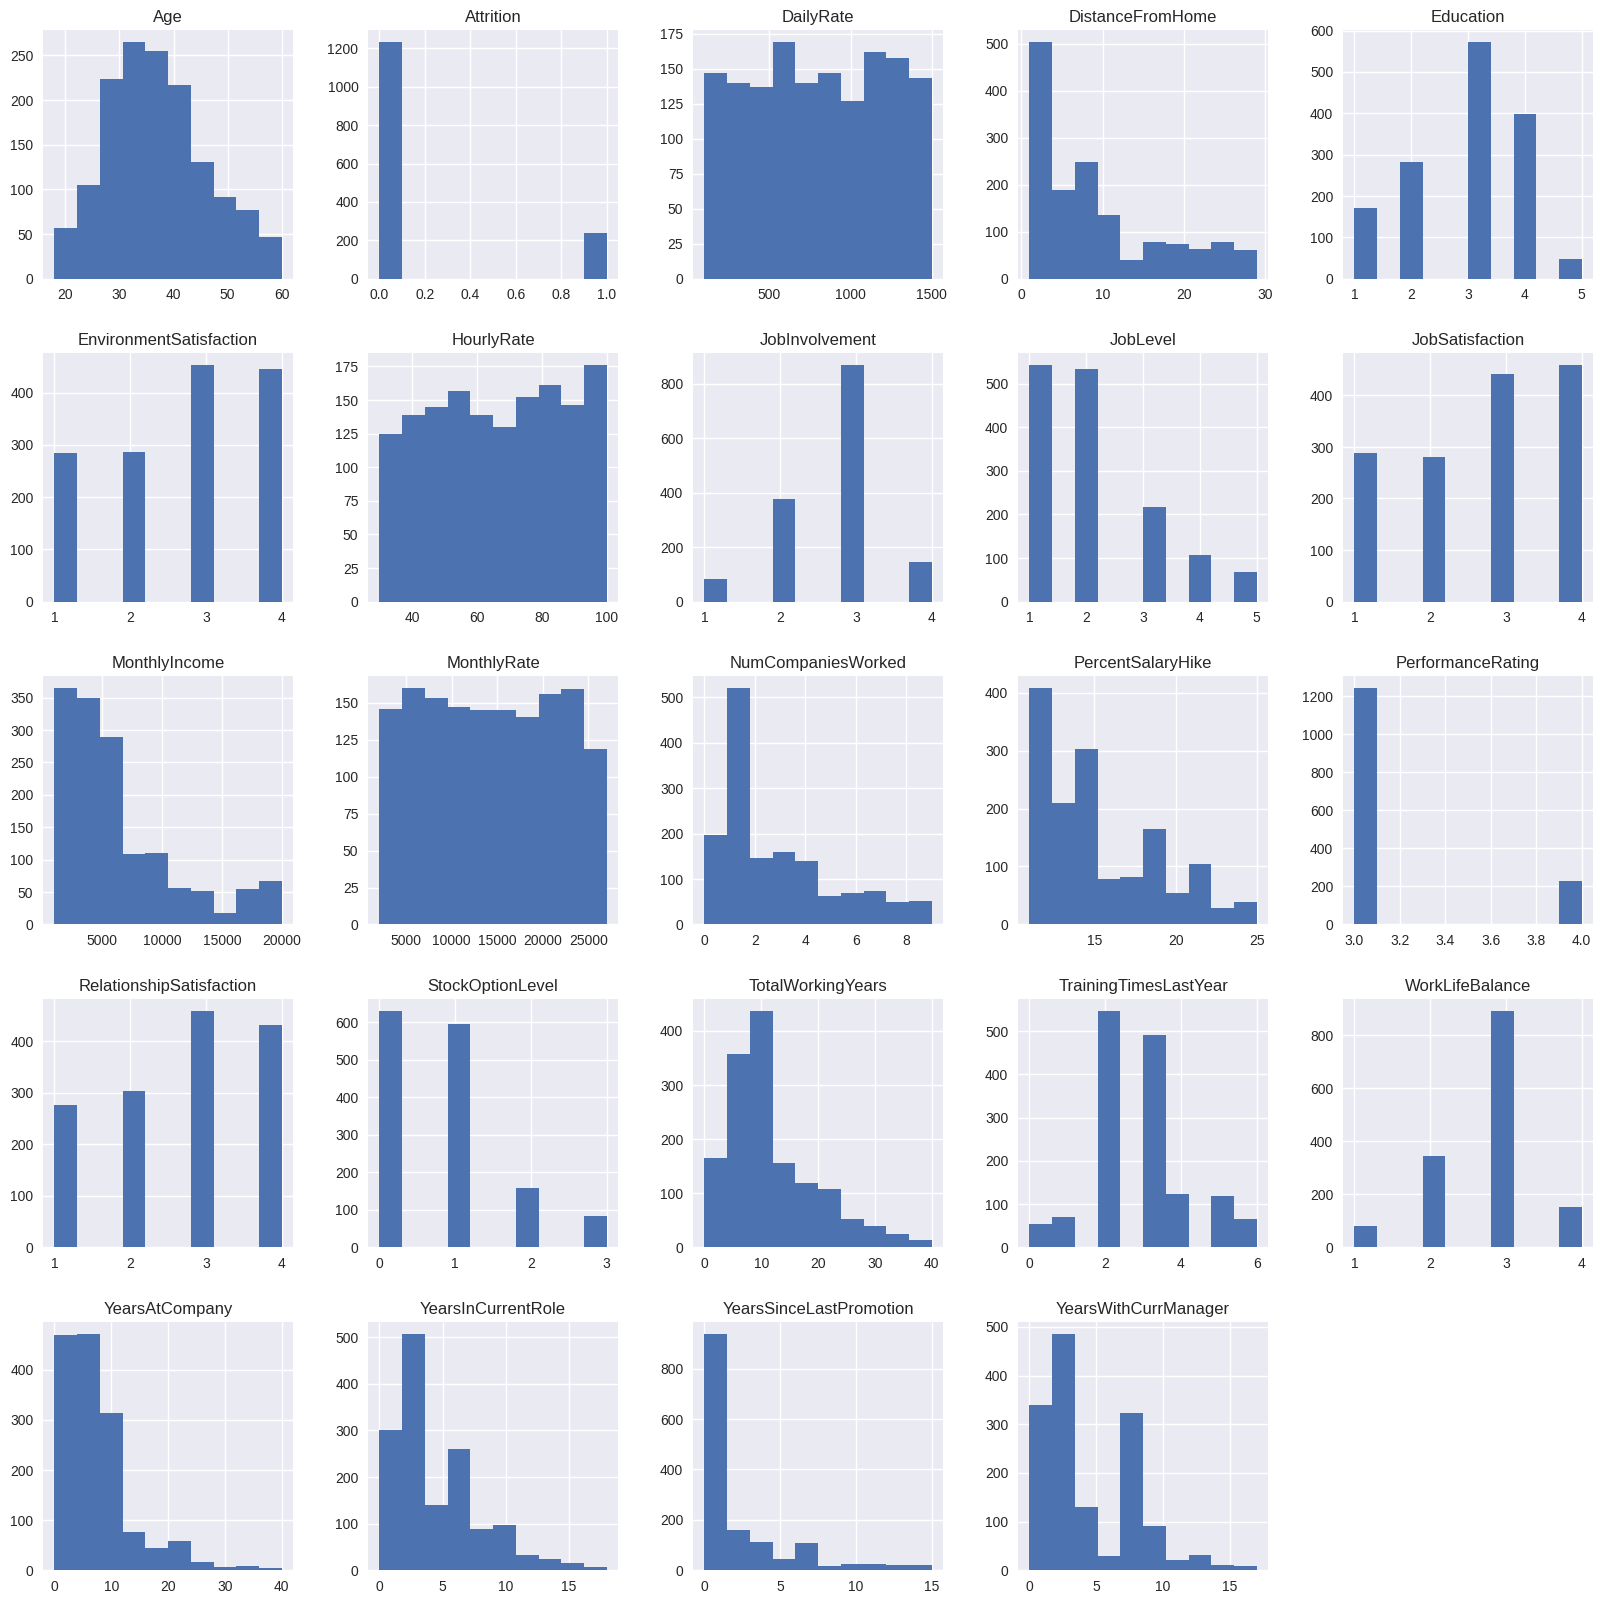

In [15]:
# Visulazing the distibution of the data for every feature
df.hist(figsize=(20, 20));

<br>

**Bar Charts**

This time, let's plot a bar graph of each categorial feature against the target class (i.e. the class we'd like to predict, 'Attrition' in this case). What the bar graph shows is the mean attrition (which we can calculate because of label encoding attrition) for each category. The short black vertical lines represent error bars.

We can, also, visualize the <b>correlations</b> using Bar Charts. The bar chart allows us to identify which pairs of variables are strongly correlated (positively and negatively), which have weak correlations, and which ones are not significantly different from 0 (showing no correlation).

**Which Category in each categorical feature has higher attrition rates than the others?**

In [16]:
categorical_features = categorical_col.copy()
categorical_features.remove('Attrition')

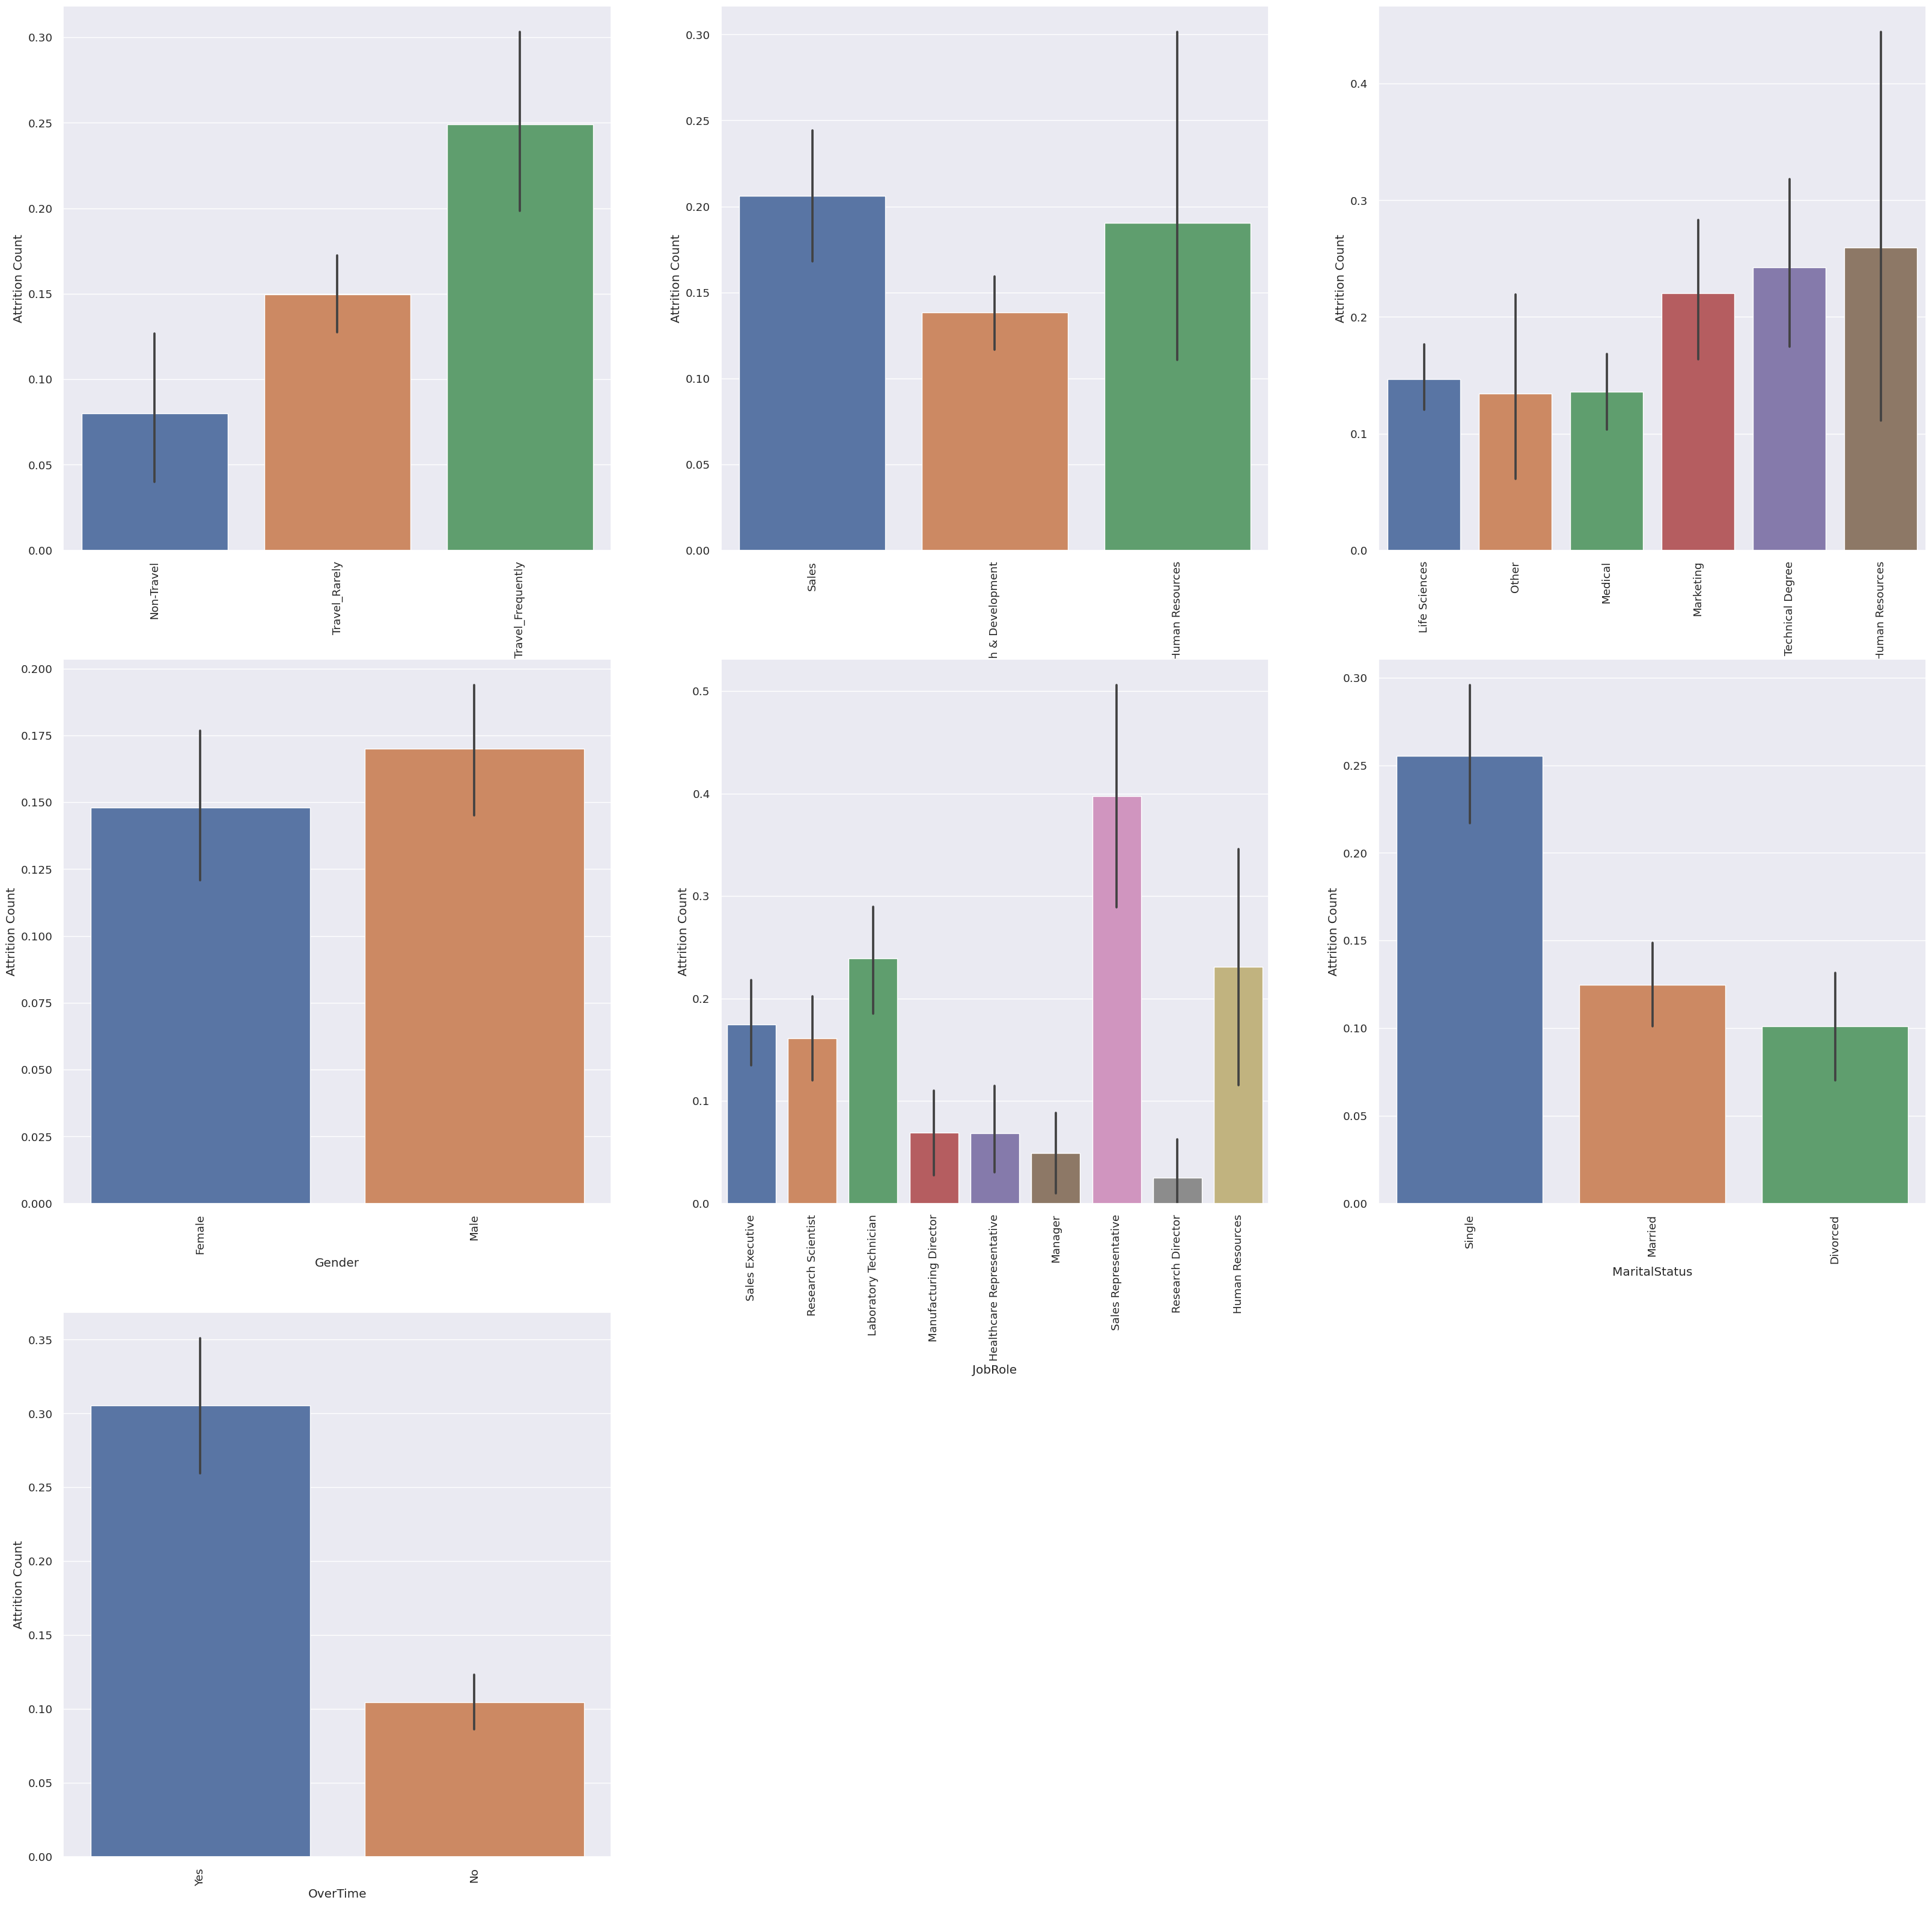

In [17]:
# Plotting every feature average in relation to the "target"
sns.set(font_scale=1.2)
plt.figure(figsize=(40, 40))

for i, column in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    g = sns.barplot(x=column, y='Attrition', data=df)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.ylabel('Attrition Count')
    plt.xlabel(f'{column}')

**Conclusions:**

- `BusinessTravel` : The workers who travel a lot are more likely to quit than other employees.

- `Department` : The worker in `Research & Development` are more likely to stay than the workers in other departments.

- `EducationField` : The workers with `Human Resources` and `Technical Degree` are more likely to quit then employees from other fields of education.

- `Gender` : `Male`s are more likely to quit.

- `JobRole` : The workers in `Laboratory Technician`, `Sales Representative`, and `Human Resources` are more likely to quit than workers in other positions.

- `MaritalStatus` : The workers who have `Single` marital status are more likely to quit the `Married` and `Divorced`.

- `OverTime` : The workers who work more hours are likely to quit than others.

## Data Pre-Processing

Although decision trees are able to handle both numerical and categorical data, `scikit-learn` current implementation (as of version 1.1.3) does not support categorical data.

In [18]:
df_encoded = df.copy()

In [19]:
# Since we've already 'BusinessTravel' is already of type 'category',
# we can use its .cat.codes attribute to preserve its order

df_encoded['BusinessTravel'] = df_encoded['BusinessTravel'].cat.codes
df_encoded['BusinessTravel']

0       1
1       2
2       1
3       2
4       1
       ..
1465    2
1466    1
1467    1
1468    2
1469    1
Name: BusinessTravel, Length: 1470, dtype: int8

In [20]:
categorical_features.remove('BusinessTravel')

Since we have to encode the categorical attributes, there are two approaches we can use: label encoding, and one-hot encoding.

**More on Encoding**

Label encoding assigns each category a unique integer. By default, if no ordering is specified, the alphabetical ordering of the categories is used. This may cause issues in model learning if the category is nominal, e.g. 'Egypt' and 'Ecuador' would be considered similar to a model like K-NN because of label encoding.

One-Hot Encoding (described in the previous lab) should generally be used when:

- The categorical feature is nominal
- The number of categories is low

Label encoding should generally be used when:

- The categorical feature is ordinal
- The number of categories is large (causing high memory consumption and computationally expensive models when using one-hot encoding)


We'll first encode the binary columns.

Note how we did not set `drop_first=True` this time, as all the categories are necessary for the classification model to learn from and classify upon, otherwise we will be losing information

In [21]:
df_encoded = pd.get_dummies(df_encoded, columns=categorical_features)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 50 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Age                                1470 non-null   int64
 1   Attrition                          1470 non-null   int8 
 2   BusinessTravel                     1470 non-null   int8 
 3   DailyRate                          1470 non-null   int64
 4   DistanceFromHome                   1470 non-null   int64
 5   Education                          1470 non-null   int64
 6   EnvironmentSatisfaction            1470 non-null   int64
 7   HourlyRate                         1470 non-null   int64
 8   JobInvolvement                     1470 non-null   int64
 9   JobLevel                           1470 non-null   int64
 10  JobSatisfaction                    1470 non-null   int64
 11  MonthlyIncome                      1470 non-null   int64
 12  MonthlyRate         

We'll just need to remove the redundant duplicate binary columns before proceeding

In [22]:
df_encoded.drop(['OverTime_No', 'Gender_Female'], axis='columns', inplace=True)
df_encoded.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'DistanceFromHome',
       'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'Department_Human Resources', 'Department_Research & Development',
       'Department_Sales', 'EducationField_Human Resources',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'Gender_Male',
       'JobRole_Healthcare Representative', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing D

As always, we need to split the data into a training dataset and a testing dataset to assess the model's generalizability on unseen data.

As per [scikit-learn's documentation](https://scikit-learn.org/stable/modules/cross_validation.html):

>Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set X_test, y_test.

In [23]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('Attrition', axis=1)
y = df_encoded['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Modelling Using The Decision Tree Classifier


### Decision Tree Parameters

The [decision tree classifier class](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) has multiple optional arguments that can be set to control the model's learning process. These are called _hyperparameters_ and often have an impact on the model's training speed and final model accuracy. For example, the `criterion` by which to measure the quality of a split can be set to `gini` for the Gini impurity or `entropy` for the information gain; or, `max_depth` can be set to a particular value as a potential solution to avoid overfitting with deep decision tree levels. We'll leave the decision tree with its defaults for now.

In [24]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

## Model Evaluation

We have different methods and metrics for evaluating the results of a classifier, For example:

Accuracy it is simply a ratio of correctly predicted observation to the total observations. Accuracy = TP+TN/TP+FP+FN+TN

Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. Precision = TP/TP+FP

Recall is the ratio of correctly predicted positive observations to total actual positive observations. Recall = TP/TP+FN

Below is a table called confusion matrix, it is usually used to show a summary of prediction results of a classifier.

![recall%20and%20perc.png](attachment:recall%20and%20perc.png)Source:[Towards Data Science](https://towardsdatascience.com/precision-and-recall-made-simple-afb5e098970f)

Let's Look at our model's performance and see the Confusion Matrix for it.

Below is just a helper function we'll use later on that prints out some of the model's performance metrics in a nicely formatted block of text.

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:")
        print("===============================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")

    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:")
        print("===============================================")
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

<br>

**Choosing the Evaluation Metric/s to use:**

Since this dataset contains <b>_imbalanced classes_</b>, it is more useful to look at <b>sensitivity/recall and precision</b> and <b>NOT to accuracy or error rate</b>.

Evaluation using the training dataset is done only for demonstrative purposes. Decision trees, at their default values set by sklearn, tend to overfit to the training dataset. Note the 100% accuracy score when evaluating the training set, but 80% accuracy score with the test set.

In [26]:
print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision   1.00   1.00      1.00       1.00          1.00
recall      1.00   1.00      1.00       1.00          1.00
f1-score    1.00   1.00      1.00       1.00          1.00
support   853.00 176.00      1.00    1029.00       1029.00
_______________________________________________
Confusion Matrix: 
 [[853   0]
 [  0 176]]

Test Result:
Accuracy Score: 79.37%
_______________________________________________
CLASSIFICATION REPORT:
               0     1  accuracy  macro avg  weighted avg
precision   0.89  0.29      0.79       0.59          0.81
recall      0.87  0.33      0.79       0.60          0.79
f1-score    0.88  0.31      0.79       0.59          0.80
support   380.00 61.00      0.79     441.00        441.00
_______________________________________________
Confusion Matrix: 
 [[330  50]
 [ 41  20]]



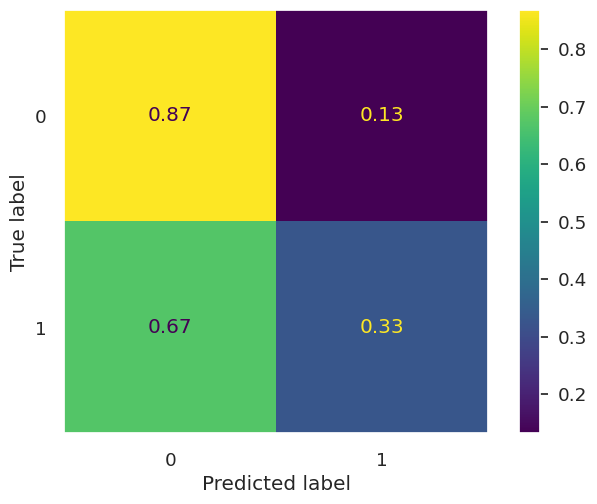

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, tree_clf.predict(X_test), labels=tree_clf.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=tree_clf.classes_)
disp.plot()
plt.grid(False)

In [28]:
from sklearn.metrics import f1_score, precision_score, recall_score

pred = tree_clf.predict(X_test)

print('Precision: ',precision_score(y_test,pred))
print('=======================================')
print('Recall: ',recall_score(y_test,pred))
print('=======================================')
print('F1_score: ',f1_score(y_test,pred))

Precision:  0.2857142857142857
Recall:  0.32786885245901637
F1_score:  0.30534351145038163


## Decision Tree Visualization

`graphviz` is an open-source library for graph visualization. We'll use it to plot the decision tree graph instead of [scikit_learn's `plot_tree`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html#sklearn.tree.plot_tree) function for its added customization and clarity.

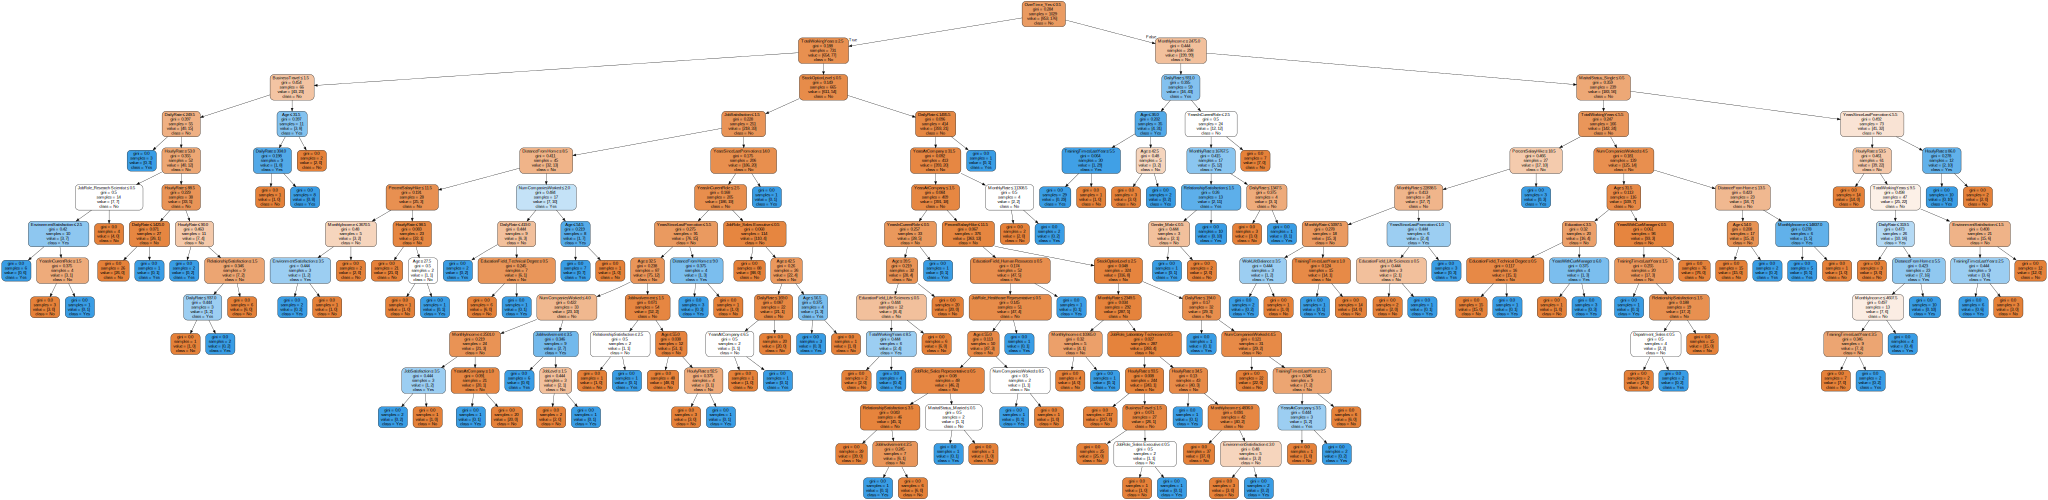

In [29]:
import graphviz
from sklearn.tree import export_graphviz
dot_data = export_graphviz(tree_clf, out_file=None,
                           feature_names=X.columns,
                           class_names=['No', 'Yes'],
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph
# alternatively, to export:
# graph.render('attrition')

## Cross-Validation & Metric Selection

When evaluating different settings ("hyperparameters") for models, there is still a risk of overfitting on the test set because the parameters can be tweaked until the model performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called "validation set": training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set. For this problem, stratified k-fold cross-validation will be used to conserve the same percentage of samples of each class in each fold.

| |
|-|
|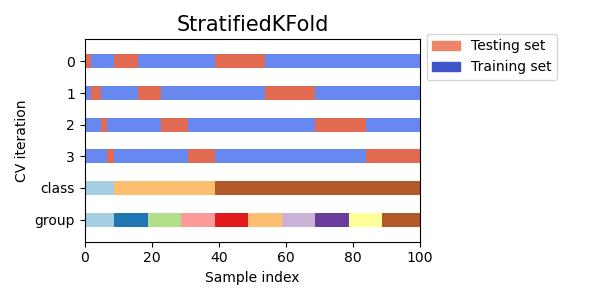|
|Source: [Stratified K-Fold Cross-Validation. Scikit-learn.](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold)|

Choosing an appropriate metric is a challenging task in machine learning, and even more so when dealing with imbalanced classes. Since we want to lower employee turnover, we want to _correctly_ predict _employees who will quit_ (true positive class), perhaps to provide them with incentives to stay, we need to consider using recall, since we want a low rate of false negatives (i.e. employees who will quit but predicted _falsely_ as _not quitting_). On the other hand, we also don't want to to have all the employees to be predicted _falsely_ as _quitting_, so precision is also a metric we should consider. Thus we'll use the f-measure as our metric for assessing the model, since it calculates the [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) of precision and recall.

$$F_1 = (\frac{\mathrm{recall}^{-1} + \mathrm{precision}^{-1}}{2})^{-1} = 2 \cdot \frac{ \mathrm{precision} \cdot  \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

clf = DecisionTreeClassifier(random_state=42)
# since we have a relatively small dataset (~1000 records),
# we'll use a low number of splits
skf = StratifiedKFold(n_splits=3)

# Note how cross validation is applied on the training dataset
# The testing dataset is always left out and used -only- in the final evaluation
scores = cross_val_score(clf, X_train, y_train, cv=skf, scoring='f1')
scores

array([0.36220472, 0.36697248, 0.32      ])

In [31]:
print("Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Score: 0.35 (+/- 0.04)


## Extra: Decision Tree Classifier Hyperparameter Tuning

Instead of tweaking the hyperparameters manually to improve model learning and performance, we can use grid search techniques to search for the best cross-validation score out of a set of hyperparameter combinations.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params = {
    "criterion":("gini", "entropy"),
    "splitter":("best", "random"),
    "max_depth":(list(range(1, 20))),
    "min_samples_split":[2, 3, 4],
    "min_samples_leaf":list(range(1, 20)),
}

tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="recall", n_jobs=-1, verbose=1, cv=3)
tree_cv.fit(X_train, y_train)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(X_train, y_train)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 3 folds for each of 4332 candidates, totalling 12996 fits


## References

Brownlee, J. (2020). Bagging and Random Forest Ensemble Algorithms for Machine Learning. Machine Learning Mastery. Retrieved from https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning

Woutersen, K., Guadron, L., van den Berg, A. V., Boonstra, F. N., Theelen, T., & Goossens, J. (2017). A meta-analysis of perceptual and cognitive functions involved in useful-field-of-view test performance. Journal of vision, 17(14), 11-11.

Cross Validation (n.d.). Scikit-learn. Retreieved from https://scikit-learn.org/stable/modules/cross_validation.html

Decision Trees (n.d.). Scikit-learn. Retreieved from https://scikit-learn.org/stable/modules/tree.html

Ensemble methods (n.d.). Scikit-learn. Retreieved from https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees

Hyperparameter Tuning the Random Forest in Python (n.d.). Retrieved from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

Kashnitsky, Y. (2019). Topic 3 - Decision Trees and kNN. Open Machine Learning Course (openml.ai). Retrieved from https://www.kaggle.com/kashnitsky/topic-3-decision-trees-and-knn

Sayah, F. (2020). Decision Trees and Random Forest for Beginners. Kaggle. Retreived from https://www.kaggle.com/faressayah/decision-trees-and-random-forest-for-beginners

## Acknowledgement

This lab is primarily based on Fares Sayah's [Decision Trees and Random Forest for Beginners](https://www.kaggle.com/faressayah/decision-trees-and-random-forest-for-beginners) notebook on Kaggle.